# Import Libraries

In [ ]:
import numpy as np
from tensorflow import keras
from keras.utils import plot_model

import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet import decode_predictions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report,roc_auc_score
from sklearn.preprocessing import label_binarize

import os
import shutil
from zipfile import ZipFile

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Collect the data

## When using the notebook in colab, to download the dataset from Kaggle put the kaggle.json file to .kaggle folder.

dataset link: [kareemabdelhamed/sign-language-digits-images-dataset](https://www.kaggle.com/datasets/kareemabdelhamed/sign-language-digits-images-dataset)

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kareemabdelhamed/sign-language-digits-images-dataset

Dataset URL: https://www.kaggle.com/datasets/kareemabdelhamed/sign-language-digits-images-dataset
License(s): CC0-1.0
  0% 0.00/16.5M [00:00<?, ?B/s]
100% 16.5M/16.5M [00:00<00:00, 1.12GB/s]


In [ ]:
file_name = "/content/sign-language-digits-images-dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall("./")
  print('done')

done


## Check file count for each digit class

In [ ]:
src_base_dir="Sign-Language-Digits-Dataset-master/Dataset"
for folder in os.listdir(src_base_dir):
  p=os.path.join(src_base_dir, folder)
  print(f"{len(os.listdir(p))} files")


204 files
207 files
206 files
207 files
208 files
205 files
207 files
206 files
206 files
206 files


In [ ]:
sorted(os.listdir(src_base_dir))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Split dataset for training, validation and testing

In [ ]:
tgt_base_dir = "SignData"

# Create output directories
categories = sorted(os.listdir(src_base_dir))

#for each category: 'Dog', 'Cat', move images into train, val, and test folders in target directory
for category in categories:
    category_path = os.path.join(src_base_dir, category)
    #finding the images of that category
    images = os.listdir(category_path)
    np.random.shuffle(images)

    # Calculate split sizes
    train_size = 150
    val_size = 27
    test_size = 27

    train_files = images[:train_size]
    val_files = images[train_size : train_size + val_size]
    test_files = images[train_size + val_size: train_size + val_size + test_size]

    # Move files
    for file in train_files:
        os.makedirs(os.path.join(tgt_base_dir, 'train', category), exist_ok=True)
        shutil.move(os.path.join(category_path, file), os.path.join(tgt_base_dir, "train", category, file))
    for file in val_files:
        os.makedirs(os.path.join(tgt_base_dir, 'val', category), exist_ok=True)
        shutil.move(os.path.join(category_path, file), os.path.join(tgt_base_dir, "val", category, file))
    for file in test_files:
        os.makedirs(os.path.join(tgt_base_dir, 'test', category), exist_ok=True)
        shutil.move(os.path.join(category_path, file), os.path.join(tgt_base_dir, "test", category, file))

print("Data successfully split into train, val, and test sets!")

Data successfully split into train, val, and test sets!


In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)\
            .flow_from_directory(directory=f"{tgt_base_dir}/train",classes=categories,batch_size=10, target_size=(224,224),shuffle=True)
val_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)\
            .flow_from_directory(directory=f"{tgt_base_dir}/val",classes=categories,batch_size=10, target_size=(224,224),shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)\
            .flow_from_directory(directory=f"{tgt_base_dir}/test",classes=categories,batch_size=10, target_size=(224,224), shuffle=False)

Found 1500 images belonging to 10 classes.
Found 270 images belonging to 10 classes.
Found 270 images belonging to 10 classes.


In [ ]:
train_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

# Visualize data and associated label

(10, 224, 224, 3)


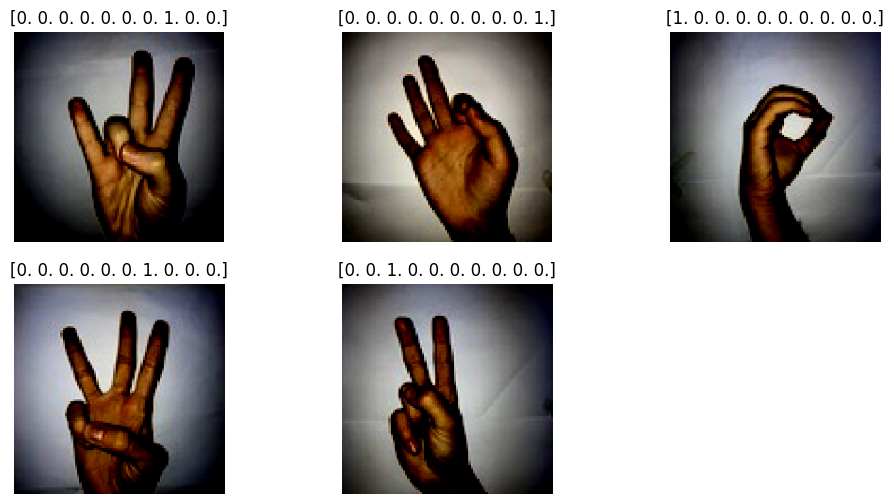

In [ ]:
imgs,lbls=next(train_batches)
plt.figure(figsize=(12,6))
for i in range(5):
  plt.subplot(2,3,i+1)
  plt.imshow(imgs[i])
  plt.title(lbls[i])
  plt.axis('off')
print(imgs.shape)

# Device setup

In [ ]:
physical_devices=tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPUs available:{len(physical_devices)}")
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Number of GPUs available:1


# Load Mobilenet

In [ ]:
mobilenet=tf.keras.applications.mobilenet.MobileNet()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Visualize mobilenet architecture

In [ ]:
mobilenet.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,253,864 (16.23 MB)

 Trainable params: 4,231,976 (16.14 MB)

 Non-trainable params: 21,888 (85.50 KB)

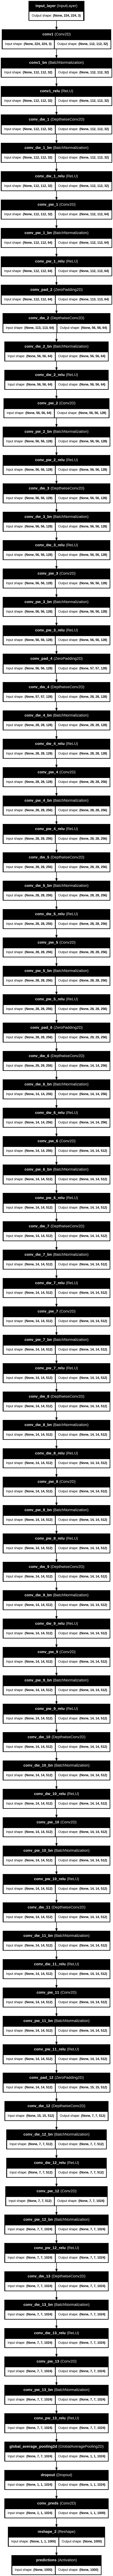

In [ ]:
plot_model(mobilenet, show_shapes=True, show_layer_names=True)

# Add Dense layer head in place of mobilenet output layer for learning digit classification

In [ ]:
layer_of_mobilenet_as_input=mobilenet.layers[-2].output
custom_output_layer=Dense(units=10,activation='softmax')(layer_of_mobilenet_as_input)
model=Model(inputs=mobilenet.input, outputs=custom_output_layer)

# Visualize the model architecture

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 4,263,874 (16.27 MB)

 Trainable params: 4,241,986 (16.18 MB)

 Non-trainable params: 21,888 (85.50 KB)

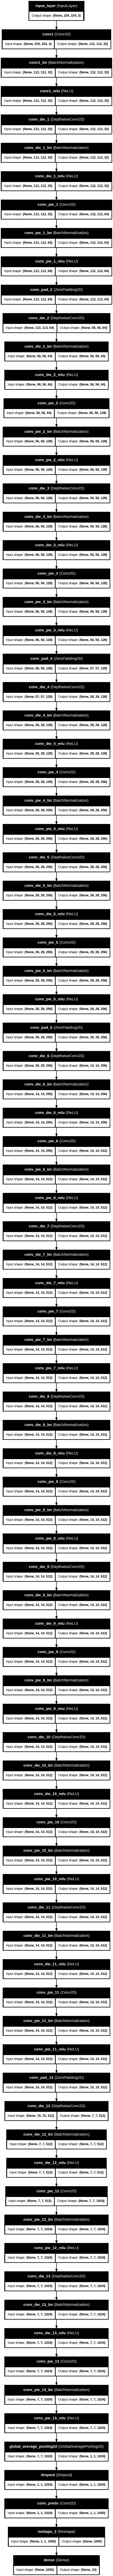

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Freeze mobilenet internal layers

In [ ]:
for layer in model.layers[-2::-1]:
    layer.trainable=False

# Train the model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_batches, validation_data=val_batches, epochs=30, verbose=1)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.1779 - loss: 3.0007 - val_accuracy: 0.4185 - val_loss: 1.7018
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4887 - loss: 1.5326 - val_accuracy: 0.5667 - val_loss: 1.2135
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6303 - loss: 1.1336 - val_accuracy: 0.6852 - val_loss: 0.9686
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6949 - loss: 0.8883 - val_accuracy: 0.7444 - val_loss: 0.8059
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7792 - loss: 0.7105 - val_accuracy: 0.7704 - val_loss: 0.7065
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8087 - loss: 0.6058 - val_accuracy: 0.8111 - val_loss: 0.6591
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8350 - loss: 0.5206 - val_accuracy: 0.8185 - val_loss: 0.5919
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8742 - loss: 0.4501 - val_accuracy: 0.85

# Make inference on test data

In [ ]:
preds=model.predict(x=test_batches)
preds

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


array([[9.9928278e-01, 1.9237131e-04, 5.1668339e-04, ..., 2.5929219e-07,
        1.0468037e-06, 8.4340445e-07],
       [9.9699980e-01, 6.1276864e-04, 2.3026967e-03, ..., 1.5963781e-06,
        1.7270224e-05, 1.7569919e-05],
       [9.9739492e-01, 1.5710690e-03, 5.0690665e-05, ..., 8.5890527e-08,
        2.4326497e-05, 9.0894882e-06],
       ...,
       [2.0064901e-06, 2.4544874e-05, 2.0582338e-04, ..., 4.6958262e-03,
        6.8807565e-02, 9.1467470e-01],
       [9.3541912e-06, 3.5716777e-05, 1.8930915e-04, ..., 5.4970168e-04,
        1.7497127e-03, 9.3054384e-01],
       [1.3045919e-06, 8.4663061e-06, 8.3170438e-05, ..., 3.7061231e-04,
        1.2381822e-02, 8.7454045e-01]], dtype=float32)

In [ ]:
y_true=test_batches.classes
y_pred=np.argmax(preds, axis=1)

# Model Evaluation Metrics

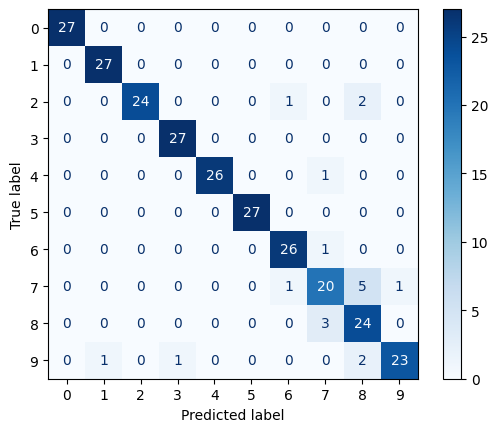

In [ ]:
cm=confusion_matrix(y_true, y_pred)
# Display confusion matrix with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)  # You can change the colormap if needed
plt.show()

In [ ]:
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9296296296296296


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.96      1.00      0.98        27
           2       1.00      0.89      0.94        27
           3       0.96      1.00      0.98        27
           4       1.00      0.96      0.98        27
           5       1.00      1.00      1.00        27
           6       0.93      0.96      0.95        27
           7       0.80      0.74      0.77        27
           8       0.73      0.89      0.80        27
           9       0.96      0.85      0.90        27

    accuracy                           0.93       270
   macro avg       0.93      0.93      0.93       270
weighted avg       0.93      0.93      0.93       270



In [ ]:

# Binarize the labels for multi-class ROC AUC
y_true_bin = label_binarize(y_true, classes=np.arange(10))

# ROC AUC score (macro-average)
roc_auc = roc_auc_score(y_true_bin, preds, average='macro', multi_class='ovr')
print("ROC AUC Score (macro):", roc_auc)

ROC AUC Score (macro): 0.9962658131382411


# Save the model

In [ ]:
model.save("mobilenet_gesture_model.keras")